In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, N_bc, s, t_test, del_t):
    
    x_train = np.linspace(x_l,x_r,N_x)
    dx = (x_r - x_l)/(N_x - 1)
    x_train = np_to_torch(x_train)
    
    return x_train, dx

def initial_temp(N_x, N_bc, T_l, T_r, N_x_test):

    T_prev_1 = np.zeros(N_x)
    T_prev_1[0] = T_l
    T_prev_2 = np.ones(N_bc)*T_l
    T_prev = np.concatenate((T_prev_1, T_prev_2),0)
    T_prev = np_to_torch(T_prev)
    
    T_test_prev = np.zeros(N_x_test)
    T_test_prev[0] = T_l
    T_test_prev = np.reshape(T_test_prev,(N_x_test, 1))
    
    return T_prev

def initial_fraction(N_x, N_bc, N_x_test):

    f_1 = np.zeros(N_x)
    f_1[0] = 1
    f_2 = np.ones(N_bc)*1
    f = np.concatenate((f_1, f_2),0)
    f = np_to_torch(f)
    
    f_test = np.zeros(N_x_test)
    f_test[0] = 1
    f_test = np.reshape(f_test,(N_x_test, 1))
    
    return f, f_test
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 1):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())

        self.fc = nn.Sequential(*modules)
        self.fc.apply(xavier_init)
        
    def forward(self, x_train):
        op = self.fc( x_train )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]

        return op, op_x2
    
def get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, f_prev, del_t, t_test):
    
    mse = nn.MSELoss(reduction='sum')
    w1 = 1
    w2 = 1
        
    T, d2Tdx2 = model(x_train)
    
    eq1 = w1*torch.sum( torch.square(T - T_prev - torch.mul( torch.where(f_prev < 1,1,0), f_prev)*k1/k2 - del_t*k1*d2Tdx2 ) )/N_tot
    bc1 = w2*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)) ) )/(N_xl)
    loss = eq1 + bc1 
    
    return loss, eq1, bc1

def interface(N, T_store, x, k1, k2, t_test):
    
    lam = lamb_analytical(k1, k2)
    for j in range(N):
        if T_store[j] == 0:
            break
            
    return x[j][0], 2*lam*math.sqrt(t_test*k1)

def print_loss(epoch, loss, eq1, bc1):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())

def L2_err(N_x_test, x_test, y_an, model, T_prev, k1, k2, f_prev, N):
    
    y_pred,_  = model(x_test)
    y_pred = y_pred.detach().numpy()
    y_pred,_ =  temp_to_latent(y_pred, T_prev, k1, k2, f_prev, N)
    L2_err =  np.sum((y_an - y_pred)**2)/(N_x_test)
    return L2_err

def lamb_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x_test, x_test, t_test, T_r, k1, k2):

    y_an = np.zeros((N_x_test, 1))
    lam = lamb_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x_test):
        if(x_test[j]<s):
            y_an[j] = 1 - math.erf( x_test[j]/( 2*np.sqrt(k1*t_test) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x_test, 1))
    
    return y_an

def temp_to_latent(T, T_prev, k1, k2, f_prev, N):
    
    f = np.zeros((N,1))
    for i in range(1, N):
        
        f[i] = (T[i] - T_prev[i])*k2/() + f_prev[i]
        if f[i]<0:
            T[i] = T_prev[i]
            f[i] = 0
            continue
        if f[i]>=0 and f[i]<1:
            T[i] = T_prev[i]
            break
        if f[i]>=1 and f_prev[i]>=1:
            f[i] = 1
            continue
        if f[i]>=1 and f_prev[i]<1:
            T[i] = T_prev[i] + k1/k2*(f[i] - 1) 
            f[i] = 1
            continue
    
    for j in range(i+1, N):
        f[j] = 0
        T[j] = T_prev[j]
        
    return T, f
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t):
    
    loss_store = []
    T_store_pred = []
    s_store_pred = []
    T_store_an = []
    s_store_an = []
    t_store = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    t_test = 0
    N_tot = N_x
    print("N_tot = ", N_tot) 
    x_train, dx = x_train_data(N_x, x_l, x_r, N_bc, 0, t_test, del_t)
    
    for i in range(N_t):
        
        t_test = t_test + del_t
        t_store.append(t_test)
        print("t = ", t_test)
        print(" ")
        y_an = analytical(N_x_test, x_test_np, t_test, T_r, k1, k2)
        
        if(i==0):
            T_prev, _ = initial_temp(N_x, N_bc, T_l, T_r, N_x_test)
            f_prev, _ = initial_fraction(N_x, N_bc, N_x_test)
        else:
            x_train, N_xl = x_train_data(N_x, x_l, x_r, N_bc, s_store_pred[-1], t_test, del_t)
            
            # Update T_prev, f_prev
            T_st,_ = model(x_train) 
            T_st = T_st.detach().numpy()
            T_prev, f_prev = temp_to_latent(T_st, T_prev.detach().numpy(), k1, k2, f_prev.detach().numpy(), N_tot)
            T_prev = torch.FloatTensor(T_prev).clone().detach().requires_grad_(False)
            f_prev = torch.FloatTensor(f_prev).clone().detach().requires_grad_(False)
            
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1 = get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, f_prev, del_t, t_test)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())
            
            if epoch%2000==0:
#                 L2_norm_err = L2_err(N_x_test, x_test_torch, y_an, model, T_prev_test, k1, k2, f_prev_test, N_x_test)
                print_loss(epoch, loss, eq1, bc1)
#                 print("L2_err= ", L2_norm_err )
                print("")
            
#             if L2_norm_err<accuracy_cap :
#                 print("loss limit attained, epoch = ", epoch," L2_err= ", L2_norm_err)
#                 print("")
#                 break
                
            if eq1<6e-5 :
                print("loss limit attained, epoch = ", epoch)
                print("")
                break

        # Store the results after each time step
        T_st,_ = model(x_test_torch)   
        T_st = T_st.detach().numpy()
        T_prev_test, f_prev_test = temp_to_latent(T_st, T_prev_test, k1, k2, f_prev_test, N_x_test)
        T_store_pred.append(T_prev_test)
        T_an = analytical(N_x_test, x_test_np, t_test, T_r, k1, k2)
        T_store_an.append(T_an)
        s_pred, s_an = interface(N_x_test, T_prev_test, x_test_np, k1, k2, t_test)
        s_store_pred.append(s_pred)
        s_store_an.append(s_an)
        
        print("broke inner loop")
        print("")

    return loss_store, T_store_pred, T_store_an, x_test_np, s_store_pred, s_store_an, t_store, f_prev_test

In [3]:
N_x = 2000
N_bc = 30
N_t = 20
del_t = 0.005
x_l = 0
x_r = 0.5
T_r = 0
T_l = 1
t_i = 0
accuracy_cap = 0.00035
N_x_test = 751

# Neural network params
layer_size = [1, 20, 20, 20, 1]

# material params
k1 = 0.05
k2 = 0.8

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 2.5e-4
epochs = 30001
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
start = time.time()
loss_store, T_store_pred, T_store_an, x_test_np, s_pred, s_an, t, f_prev_test = train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t)
end = time.time()
time_elapsed = end - start
print("time elapsed = ", time_elapsed)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
    (7): Tanh()
  )
)
Total trainable parameters in the model: 901
N_tot =  781
t =  0.005
 
epoch =  0
loss =  1.5069346
eq1_loss =  0.0814279
bc1_loss =  1.4255067

epoch =  2000
loss =  0.09795994
eq1_loss =  0.06971455
bc1_loss =  0.02824539

epoch =  4000
loss =  0.042933583
eq1_loss =  0.031384557
bc1_loss =  0.011549027

epoch =  6000
loss =  0.0369382
eq1_loss =  0.024325028
bc1_loss =  0.012613173

epoch =  8000
loss =  0.018605927
eq1_loss =  0.0056070685
bc1_loss =  0.0129988585

epoch =  10000
loss =  0.0090724705
eq1_loss =  0.0020068262
bc1_loss =  0.0070656445

epoch =  12000
loss =  0.005835752
eq1_loss =  0.0009135815
bc1_loss =  0.0049221707

epoch =  14000
loss 

# Results Plotter

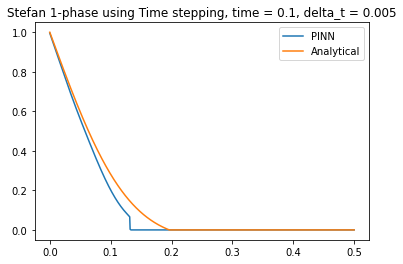

In [4]:
j = 19
i = 0
k = N_x_test
plt.plot(x_test_np[i:k], T_store_pred[j][i:k])
plt.plot(x_test_np[i:k], T_store_an[j][i:k])
Title = "Stefan 1-phase using Time stepping, " + "time = " + str((j+1)*del_t) + ", delta_t = " + str(del_t)
plt.title(Title)
plt.legend(["PINN", "Analytical"])
plt.show()

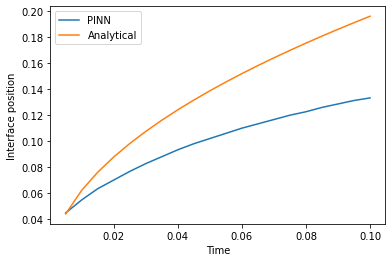

In [5]:
plt.plot(t, s_pred)
plt.plot(t, s_an)
plt.legend(["PINN", "Analytical"])
plt.xlabel('Time')
plt.ylabel('Interface position')
plt.show()